In [2]:
# Phase 3 — Business Data Quality (BDQ)
import sys, os
sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)


Matplotlib is building the font cache; this may take a moment.


In [3]:
cleaned_paths = {
    "visitor_events": "../data/cleaned/visitor_events.csv",
    "applications": "../data/cleaned/applications.csv",
    "accounts": "../data/cleaned/accounts.csv",
    "transactions": "../data/cleaned/transactions.csv",
    "marketing_source": "../data/cleaned/marketing_source.csv"
}

cleaned = {name: pd.read_csv(path) for name, path in cleaned_paths.items()}

for name, df in cleaned.items():
    print(name, df.shape)


visitor_events (148999, 9)
applications (15000, 9)
accounts (5980, 6)
transactions (298006, 7)
marketing_source (6, 3)


In [4]:
###############################################
### BDQ CHECK FUNCTIONS (Combined)          ###
###############################################

def fk_check(parent_df, parent_key, child_df, child_fk):
    parent_ids = set(parent_df[parent_key].dropna().astype(str))
    mask = ~child_df[child_fk].astype(str).isin(parent_ids)
    return child_df[mask]


def value_range_check(df, col, min_value=None, max_value=None, allow_null=True):
    s = df[col]
    mask = pd.Series(False, index=df.index)
    if not allow_null:
        mask |= s.isnull()
    if min_value is not None:
        mask |= (s < min_value)
    if max_value is not None:
        mask |= (s > max_value)
    return df[mask]


def categorical_check(df, col, valid_set):
    valid = {str(x).lower() for x in valid_set}
    mask = df[col].astype(str).str.lower().apply(lambda x: x not in valid)
    return df[mask]


def logical_check_date_order(df, earlier_col, later_col):
    e = pd.to_datetime(df[earlier_col], errors="coerce")
    l = pd.to_datetime(df[later_col], errors="coerce")
    return df[e > l]


def psi(expected, actual, bins=10):
    expected = np.array(expected)
    actual = np.array(actual)

    expected = expected[~np.isnan(expected)]
    actual = actual[~np.isnan(actual)]

    if len(expected) == 0 or len(actual) == 0:
        return np.nan, None

    breakpoints = np.percentile(expected, np.linspace(0, 100, bins+1))
    e_counts, _ = np.histogram(expected, breakpoints)
    a_counts, _ = np.histogram(actual, breakpoints)

    e_perc = e_counts / max(e_counts.sum(), 1)
    a_perc = a_counts / max(a_counts.sum(), 1)

    e_perc = np.where(e_perc == 0, 1e-6, e_perc)
    a_perc = np.where(a_perc == 0, 1e-6, a_perc)

    psi_vals = (e_perc - a_perc) * np.log(e_perc / a_perc)
    return psi_vals.sum(), psi_vals


def correlation_change(df_old, df_new, cols):
    old = df_old[cols].select_dtypes(include=[np.number])
    new = df_new[cols].select_dtypes(include=[np.number])
    if old.empty or new.empty:
        return None
    c_old = old.corr()
    c_new = new.corr()
    diff = (c_old - c_new).abs()
    mean_change = diff.values[np.triu_indices_from(diff.values, k=1)].mean()
    return diff, mean_change


In [5]:
issues = {}
summary = []

ve = cleaned["visitor_events"]
apps = cleaned["applications"]
accs = cleaned["accounts"]
tx = cleaned["transactions"]
marketing = cleaned["marketing_source"]

#################################
# 1. FOREIGN KEY CHECKS
#################################

# applications.visitor_id → visitor_events.visitor_id
missing_visitors = fk_check(ve, "visitor_id", apps, "visitor_id")
issues["apps_missing_visitor"] = missing_visitors
summary.append(("apps_missing_visitor", len(missing_visitors)))

# accounts.application_id → applications.application_id
missing_apps = fk_check(apps, "application_id", accs, "application_id")
issues["accs_missing_application"] = missing_apps
summary.append(("accs_missing_application", len(missing_apps)))

# transactions.account_id → accounts.account_id
missing_accs = fk_check(accs, "account_id", tx, "account_id")
issues["tx_missing_account"] = missing_accs
summary.append(("tx_missing_account", len(missing_accs)))

#################################
# 2. BUSINESS RULE CHECKS
#################################

# credit_score in [300,850]
bad_credit = value_range_check(apps, "credit_score", 300, 850)
issues["bad_credit_score"] = bad_credit
summary.append(("bad_credit_score", len(bad_credit)))

# income >= 0
bad_income = value_range_check(apps, "income", min_value=0)
issues["negative_income"] = bad_income
summary.append(("negative_income", len(bad_income)))

# status valid
bad_status = categorical_check(apps, "status", ["submitted", "approved", "rejected"])
issues["invalid_status"] = bad_status
summary.append(("invalid_status", len(bad_status)))

# accounts: deposit >= 0
bad_deposit = value_range_check(accs, "initial_deposit", min_value=0)
issues["negative_deposit"] = bad_deposit
summary.append(("negative_deposit", len(bad_deposit)))

# accounts: kyc_status valid
bad_kyc = categorical_check(accs, "kyc_status", ["verified", "pending", "failed"])
issues["bad_kyc_status"] = bad_kyc
summary.append(("bad_kyc_status", len(bad_kyc)))

# transactions: amount > 0
bad_tx_amount = value_range_check(tx, "amount", min_value=0.01)
issues["invalid_tx_amount"] = bad_tx_amount
summary.append(("invalid_tx_amount", len(bad_tx_amount)))

#################################
# 3. REFERENCE CHECK (marketing)
#################################

bad_cost = value_range_check(marketing, "channel_cost", min_value=0)
issues["marketing_invalid_cost"] = bad_cost
summary.append(("marketing_invalid_cost", len(bad_cost)))

#################################
# MAKE SUMMARY DF
#################################

summary_df = pd.DataFrame(summary, columns=["check", "num_issues"])
summary_df.sort_values("num_issues", ascending=False)


,check,num_issues
2,tx_missing_account,1000
5,invalid_status,198
4,negative_income,100
0,apps_missing_visitor,0
1,accs_missing_application,0
3,bad_credit_score,0
6,negative_deposit,0
7,bad_kyc_status,0
8,invalid_tx_amount,0
9,marketing_invalid_cost,0


In [6]:
for name, df in issues.items():
    if len(df) > 0:
        print(f"\n==== {name} (showing top 10) ====")
        display(df.head(10))



==== tx_missing_account (showing top 10) ====


,transaction_id,account_id,transaction_timestamp,amount,transaction_type,merchant_category,channel
347,561a1b3e-6a48-446e-96c5-8ef7b6694d1c,49adeb63-1650-4b10-a981-a6c7739657ca,2024-01-01 05:53:00,3779.16,debit,electronics,ATM
484,f08ee65a-2e7f-46d5-9a72-f8995725bdf4,b0563984-9088-4019-8e03-11d41dc5e7ee,2024-01-01 08:11:00,2672.45,debit,grocery,online
657,d332e83e-ec22-49ba-9a16-2c9050a516f2,9c50dcce-97ed-4943-a47a-8619e5de780d,2024-01-01 11:05:00,2565.80,credit,restaurant,ATM
815,b7e2505b-5fb3-4cf5-a8bf-7c640f8782fd,8ebd4f32-467c-4f26-ad12-e585fecf5aa0,2024-01-01 13:45:00,1222.06,credit,electronics,POS
1001,47717607-e94c-4a67-89d3-a785ace35f64,51a98b4d-f796-4f43-8af5-43f0e7a35347,2024-01-01 16:55:00,4927.35,debit,travel,ATM
1201,1fde7250-3d8f-496f-90b4-6116b2b2ef73,63e045b0-f9d5-4e22-90b2-24bee2d25d04,2024-01-01 20:17:00,1884.56,debit,electronics,ATM
1543,b026e70c-2325-4b47-90bd-91734b4498fd,dd964ce2-996a-4713-bf2f-fa746a5be2e1,2024-01-02 02:01:00,3098.00,debit,electronics,POS
1592,5687ce4f-7672-4ad7-b3ed-d49056ab268e,dd964ce2-996a-4713-bf2f-fa746a5be2e1,2024-01-02 02:51:00,1496.22,debit,restaurant,ATM
1609,51e26197-565f-4b19-89c1-6873389d9b7e,ea6a185d-2335-4843-9f6c-84814724ad7c,2024-01-02 03:09:00,907.71,credit,grocery,POS
1785,5986ea5e-d00e-4c8b-b2ba-7417c17adfe7,9c50dcce-97ed-4943-a47a-8619e5de780d,2024-01-02 06:06:00,1403.00,debit,grocery,ATM



==== negative_income (showing top 10) ====


,application_id,visitor_id,application_date,status,credit_score,income,loan_amount,product_type,source_channel
42,cece2d93-fbbb-43f8-bb2b-129dee1eb064,26387,2024-03-04,submitted,530.0,-5000,121972,personal_loan,referral
77,51680569-89fa-45a0-8481-0b2db0e91795,10339,2024-03-21,submitted,340.0,-5000,15977,credit_card,referral
83,a704e08a-0c16-401e-b95b-9f1a2603d3f7,12938,2024-02-09,submitted,412.0,-5000,85497,mortgage,email
85,bb18b5b5-b24d-4e4d-8f18-16c1a2ab41b2,26192,2024-01-10,submitted,748.0,-5000,21775,mortgage,ads
242,5499de39-dfd7-4d20-ad6f-e9e5fea8cbc3,25882,2024-02-18,approved,758.0,-5000,97159,personal_loan,direct
315,69893f7c-6d09-4151-a727-89092516afd9,21048,2024-02-24,submitted,604.0,-5000,88576,personal_loan,direct
660,317a4b1b-be49-49c8-9814-cd7ffe38fbeb,15041,2024-03-16,submitted,563.0,-5000,13343,credit_card,direct
953,74aa2284-1749-4465-9aa3-e84fd52068c7,15422,2024-02-19,submitted,629.0,-5000,94376,mortgage,email
1126,4e96a970-17da-4c51-aff9-42220e58067b,28931,2024-03-01,submitted,685.0,-5000,35789,mortgage,direct
1167,e7747ce7-16e1-4c61-a236-690f945dd768,25519,2024-03-18,rejected,824.0,-5000,67273,personal_loan,email



==== invalid_status (showing top 10) ====


,application_id,visitor_id,application_date,status,credit_score,income,loan_amount,product_type,source_channel
11,92bf2878-9141-4f22-b9ab-407ac8653f15,21576,2024-02-14,unknwon,739.0,94827,9032,mortgage,referral
33,5c94ce16-15df-40ca-8189-f09c1ea76086,28139,2024-01-26,unknwon,333.0,99472,23159,personal_loan,direct
55,42e66f9d-df50-4f63-a5bc-16875f7344af,19044,2024-02-11,unknwon,494.0,47862,99487,credit_card,email
70,810152ae-5703-42d0-92ce-f5c57ffb5afc,15413,2024-03-24,unknwon,755.0,129853,55884,personal_loan,email
144,4fdb20a0-bab1-49f1-b359-4407feaa24da,18431,2024-02-08,unknwon,410.0,38976,167613,mortgage,referral
197,b4cc9227-685f-4db3-b776-697cc28faf67,22519,2024-03-02,unknwon,541.0,20757,115558,credit_card,ads
494,05ae938e-3434-4445-ab0a-be66bd73f93c,26391,2024-02-08,unknwon,504.0,117386,190684,mortgage,referral
616,f5687d9d-d253-4614-8da7-755bcda3bad8,15536,2024-02-13,unknwon,576.0,111264,162974,personal_loan,referral
744,07af6cad-6e28-4dd7-a82e-6d9f57c6ce27,17960,2024-01-20,unknwon,338.0,22530,101490,personal_loan,ads
849,693e492a-94b1-4ede-b312-f03cd3668b85,12159,2024-02-23,unknwon,355.0,44623,35365,credit_card,referral


In [7]:
apps2 = cleaned["applications"].dropna(subset=["credit_score"])
n = len(apps2)
first = apps2["credit_score"].iloc[:int(n*0.5)].values
second = apps2["credit_score"].iloc[int(n*0.5):].values

psi_val, details = psi(first, second)
print("Credit Score PSI:", psi_val)


Credit Score PSI: 0.0013417952726377234


In [8]:
apps2 = cleaned["applications"].dropna(subset=["income", "loan_amount"])
n = len(apps2)
old = apps2.iloc[:int(n*0.3)]
new = apps2.iloc[int(n*0.7):]

diff, mean_corr_change = correlation_change(old, new, ["income", "loan_amount"])
print("Mean correlation drift:", mean_corr_change)

diff


Mean correlation drift: 0.02239750131997328


,income,loan_amount
income,0.000000,0.022398
loan_amount,0.022398,0.000000


<Figure size 800x400 with 0 Axes>

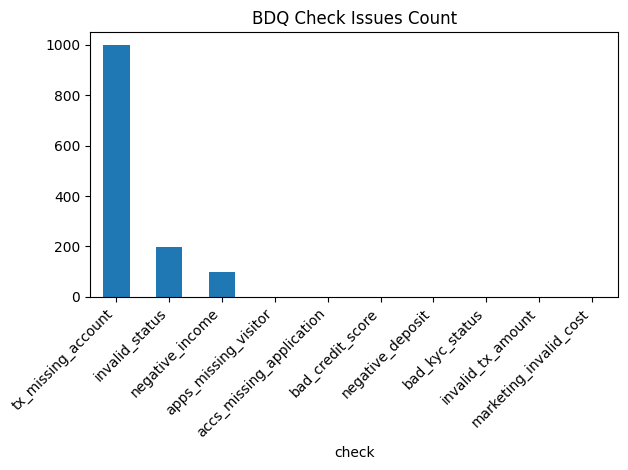

In [9]:
plt.figure(figsize=(8,4))
summary_df.sort_values("num_issues", ascending=False).plot.bar(
    x="check", y="num_issues", legend=False
)
plt.title("BDQ Check Issues Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [10]:
os.makedirs("../data/reports/", exist_ok=True)

summary_df.to_csv("../data/reports/bdq_summary.csv", index=False)

for name, df in issues.items():
    if len(df) > 0:
        df.to_csv(f"../data/reports/{name}.csv", index=False)

print("BDQ reports saved.")


BDQ reports saved.
